<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Первичный-анализ-данных" data-toc-modified-id="Первичный-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Первичный анализ данных</a></span></li><li><span><a href="#Дальнейший-план" data-toc-modified-id="Дальнейший-план-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Дальнейший план</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span><code>LogisticRegression</code></a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span><code>RandomForestClassifier</code></a></span></li><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span><code>CatBoostClassifier</code></a></span></li><li><span><a href="#XGBClassifier" data-toc-modified-id="XGBClassifier-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span><code>XGBClassifier</code></a></span></li><li><span><a href="#LGBMClassifier" data-toc-modified-id="LGBMClassifier-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span><code>LGBMClassifier</code></a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Отчет" data-toc-modified-id="Отчет-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Отчет</a></span></li></ul></div>

# Прогнозирование оттока клиентов

Наш заказчик - оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь
2. Интернет

**Цель исследования:** проанализировать данные и написать модель, которая сможет предсказывать, кто из клиентов, скорее всего, может уйти

Для начала проведем первичный анализ данных, затем напишем план.

В нашем распоряжении 4 файла:
- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии

В них следующие поля:

- `BeginDate`– дата начала пользования услугами,
- `EndDate` – дата окончания пользования услугами,
- `Type` – тип оплаты: ежемесячный, годовой и тд,
- `PaperlessBilling` – электронный платёжный документ,
- `PaymentMethod` – способ оплаты,
- `MonthlyCharges` – ежемесячные траты на услуги,
- `TotalCharges` – всего потрачено денег на услуги
- `Dependents` – наличие иждивенцев
- `Senior Citizen` – наличие пенсионного статуса по возрасту
- `Partner` – наличие супруга(и)
- `MultipleLines` – наличие возможности ведения параллельных линий во время звонка


Бизнес-метрика здесь — это убытки по двум направлениям: 
* Пользователю предложили промокоды, но он не собирался уходить (false positive)

* Пользователю ничего не предложили и он ушёл (false negative)

Так как величина промокода пока неизвестна, будет использоваться метрика, которая учитывает возможность балансировать между этими (false posititve и false negative) — `AUC-ROC`. В качестве дополнительной метрики также вычислим accuracy.

`RANDOM_STATE = 120922`<br>
Минимальные показатели `AUC-ROC` - 0.76

Для анализа дополнительно будем использовать `pandas-profiling` это позволит быстрее найти пропуски, аномалии, корреляции и т.п. если они есть (если смотреть на гитхабе, то не отобразиться, но там ничего интересного)) ):

In [2]:
# base stuff
import pandas as pd
from pandas_profiling import ProfileReport
import phik
import plotly.express as px
import optuna
import matplotlib.pyplot  as plt
from imblearn.over_sampling import SMOTE

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve 
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier

# boosting
from lightgbm import LGBMClassifier
from catboost import Pool, CatBoostClassifier
import xgboost as xgb
from lightgbm import plot_importance

`contract.csv`

## Первичный анализ данных

In [4]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
display(contract.head())
contract.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Приведем `BeginDate` к нужному типу данных:

In [5]:
contract["BeginDate"] = pd.to_datetime(contract["BeginDate"], errors="ignore")

По какой-то причине тип значений в столбце `TotalCharges` - "str". Сменим его на "float"

In [6]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors = 'coerce')

In [7]:
contract[contract['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


После преобразования в `TotalCharges` там где раньше было написано "none" теперь пропуски. Информация актуальна на 1 февраля 2020, поэтому общая сумма оплаты еще не указана. Но у нас есть данные о стоимости услуг за месяц и тип оплаты. Мы можем сами посчитать сколько выйдет общая сумма.

Для начала посчитаем сумму для оплаты раз в год, затем для оплаты раз в 2 года:

In [8]:
contract.iloc[5218] = contract.iloc[5218].fillna(contract.iloc[5218]['MonthlyCharges'] * 12)

Возьмем индексы строк с пропусками и заполним пропуски в `TotalCharges` значениями из `MonthlyCharges` умножеными на 24 (месяца):

In [9]:
for i in contract[contract['TotalCharges'].isna()].index:
    contract.iloc[i] = contract.iloc[i].fillna(contract.iloc[i]['MonthlyCharges'] * 24) 

In [10]:
display(contract[contract['TotalCharges'].isna()])
contract.iloc[488]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


customerID                         4472-LVYGI
BeginDate                 2020-02-01 00:00:00
EndDate                                    No
Type                                 Two year
PaperlessBilling                          Yes
PaymentMethod       Bank transfer (automatic)
MonthlyCharges                          52.55
TotalCharges                           1261.2
Name: 488, dtype: object

Теперь взглянем как изменялось число клиентов со временем:

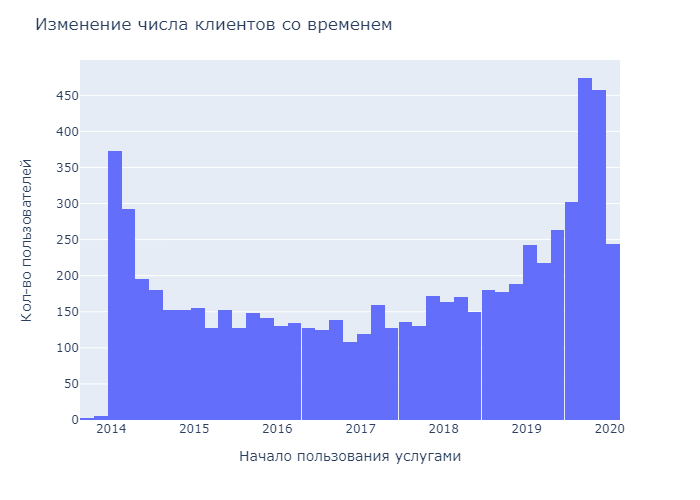

In [31]:
fig = px.histogram(contract, x='BeginDate')
fig.update_layout(xaxis_title='Начало пользования услугами', yaxis_title='Кол-во пользователей',
    title="Изменение числа клиентов со временем")

fig.show('png')

Похоже, что большой приток клиентов был, когда компания только открылась, затем рост снизился, но снова резко подскочил с августа по декабрь 2019, возможно была какая-нибудь акция, или удачная рекламная компания.

Теперь посмотрим когда ушло больше всего клиентов:

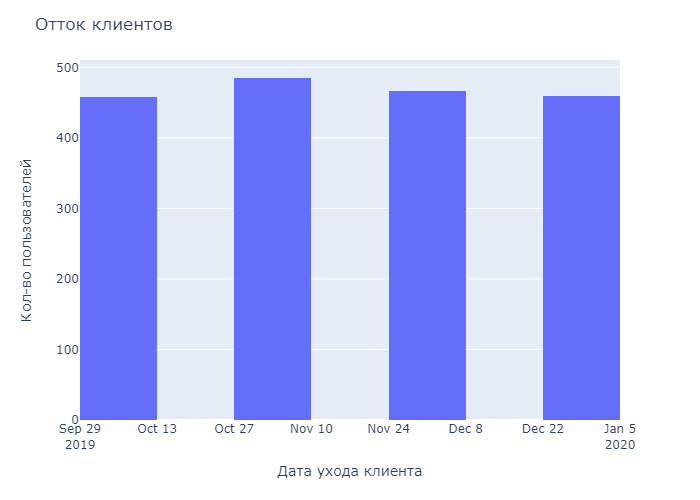

In [32]:
fig = px.histogram(contract, x='EndDate', nbins=10)
fig.update_layout(xaxis_title='Дата ухода клиента', yaxis_title='Кол-во пользователей',
    title="Отток клиентов")

fig.show('png')

Все клиенты, которые ушли, сделали это с октрября 2019 по январь 2020. Выглядит странно, как-будто никто из клиентов за несколько лет так и не ушел, а потом они вдруг решили все вместе уйти в один месяц. Возможно это связанно с тем, как состоялвяется отчетность по ушедшим клиентам, возможно они ушли давно, но их посчитали только в этих месяцах.

Посмотрим на распределение месячного счета и сравним, сколько тратят клиенты с разными типами оплаты:

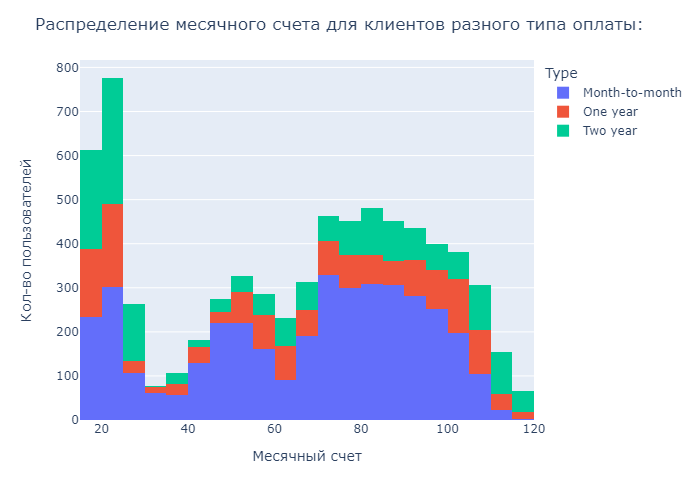

In [33]:
fig = px.histogram(contract, x='MonthlyCharges', color='Type', nbins=40)
fig.update_layout(xaxis_title='Месячный счет', yaxis_title='Кол-во пользователей',
    title="Распределение месячного счета для клиентов разного типа оплаты:")

fig.show('png')

Мы видим пик на показателях 18-25, дальше распределение более равномерное.

Взглянем на распределение в `TotalCharges`:

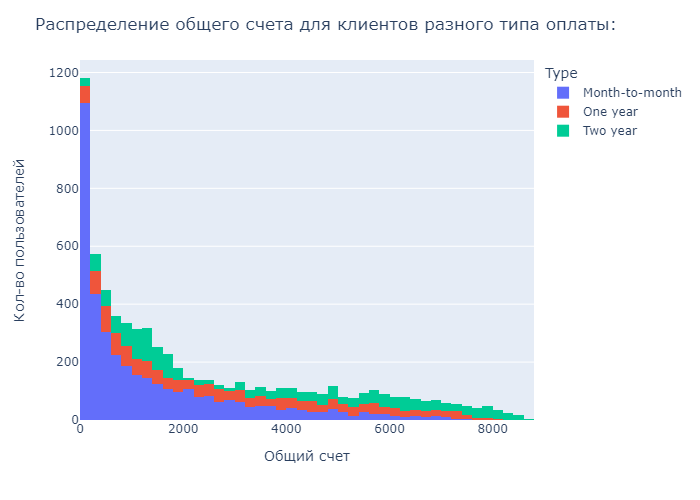

In [34]:
fig = px.histogram(contract, x='TotalCharges', color='Type')
fig.update_layout(xaxis_title='Общий счет', yaxis_title='Кол-во пользователей',
    title="Распределение общего счета для клиентов разного типа оплаты:")

fig.show('png')

Если взглянуть на распределение в `TotalCharges`, то видно, что большинство клиентов платят до 200. Похоже, что чем больше платит клиент, тем более вероятно, что тип оплаты будет либо "раз в два года", либо "раз в год".

`personal.csv`

In [15]:
personal = pd.read_csv('/datasets/final_provider/personal.csv')
display(personal.head())
personal.info()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Кол-во наблюдений столько же, значит все должно быть на месте

Взглянем на соотношение полов:

In [16]:
personal['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

Соотношение, практически, одинаковое.

Узнаем сколько пенсионеров:

In [17]:
personal['SeniorCitizen'].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

Примерно 1/7 часть от общего числа клиентов.

`internet.csv`

In [18]:
internet = pd.read_csv('/datasets/final_provider/internet.csv')
display(internet.head())
internet.info()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Кол-во наблюдений уже меньше. Скорее всего, это связано с тем, что кто-то из клиентов не пользуется интернет услугами.

`phone.csv`

In [19]:
phone = pd.read_csv('/datasets/final_provider/phone.csv')
display(phone.head())
phone.info()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Здесь кол-во наблюдений другое, значит и телефоном некоторые клиенты не пользуются.

In [20]:
phone['MultipleLines'].value_counts(normalize=True)

No     0.532935
Yes    0.467065
Name: MultipleLines, dtype: float64

Практически половина клиентов пользуются паралельными линиями.

Объеденим все в один датасет и посмотрим на profile report:

In [21]:
merged_df = pd.merge(personal, contract, how='outer')
merged_df = pd.merge(merged_df, internet, how='outer')
merged_df = pd.merge(merged_df, phone, how='outer')

Используем именно такой способ объединения, чтобы сразу знать - **там, где появились пропуски - указатель того, что клиент не пользовался этой услугой.**

In [22]:
profile = ProfileReport(merged_df)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Наш целевой признак - `EndDate` посмотрим как он связан с другими переменными.
Используем `PhiK` корреляцию, которая поможет уловить взаимосвязь для смешанных типов переменных:

interval columns not set, guessing: ['SeniorCitizen', 'MonthlyCharges', 'TotalCharges']


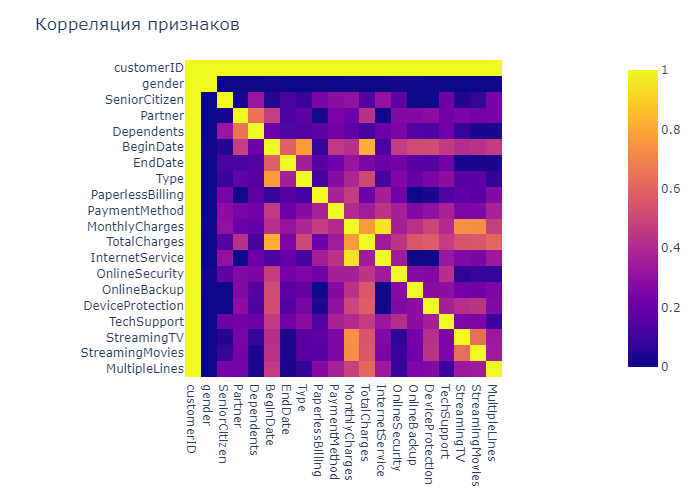

In [35]:
fig = px.imshow(merged_df.phik_matrix())
fig.update_layout(title='Корреляция признаков')
fig.show('png')

Высокая корреляция `EndDate` с `BeginDate`. Средняя с `Type`, `MonthlyCharges`, `TotalCharges`.

`EndDate` никак не коррелирует с `gender`, `StreamingTV`, `StreamingMovies`, `MultipleLines`. Возможно, если от них избавиться, то показатели моделей улучшатся.

Другие корреляции вполне логичны. Дополнительные услуги коррелируют с месячной и суммарной оплатой. Если у клиента есть супруг, то, возможно, у них есть иждивенец.

Интересно, что есть корреляция между `BeginDate` и дополнительными услугами типа `OnlineBackup`, `DeviceProtection`и т.п. Возможно, что клиенты, по началу, их не подключают, но со временем приобретают и их, если достаточно долго пользуются основными услугами.

Аномальных и выбивающихся значений нет.

## Дальнейший план
* Создадим новый столбец как целевой признак. Сформируем столбец на основе `EndDate`. Если на его место стоит `No` то в новом столбце будет значение `0`. Если `EndDate` - `любая дата` значит клиент ушел, это отметим как `1`.
* Заполним пропуски. Если они появились, значит клиент не пользуется этими услугами
* Кодируем данные с помощью `OHE` так как количество уникальных значений в признаках не велико
* Разделим данные только на тестовую и обучающую выборку, потому что данных мало 
* Обучаем модели (После обучения можно попробовать исключить наименее важные признаки, если не достигнем нужных результатов)
* Тестируем финальную модель, проверяем на адекватность 

## Предобработка данных

Создадим новый столбец `Leaving` на основе `EndDate`, в котором будет обозначенно ушел клиент или нет. Это будет нашим целевым признаком:

In [36]:
def new_EndDate(row):
    if row == 'No':
        return 0
    if row != 'No':
        return 1

merged_df['Leaving'] = merged_df['EndDate'].apply(new_EndDate)

Теперь удалим столбцы, которые, судя по корреляции, не будут влиять на наш целевой признак:

In [37]:
merged_df = merged_df.drop(['EndDate', 'customerID', 'gender', 'StreamingTV', 'StreamingMovies', 'MultipleLines'], axis=1)

Перед кодировкой заполним пропуски значением 'No', поскольку пропуски после объединения датасетов означают то, что клиент не пользовался услугами:

In [38]:
merged_df = merged_df.fillna('No')

Кодируем наши признаки с помощью OHE, потому что уникальных значений мало:

In [39]:
merged_df_ohe = pd.get_dummies(merged_df[['Partner', 
                                            'Dependents', 
                                            'Type', 
                                            'PaperlessBilling', 
                                            'PaymentMethod', 
                                            'InternetService',
                                            'OnlineSecurity',
                                            'OnlineBackup',
                                            'DeviceProtection',
                                            'TechSupport'
                                          ]],
                                drop_first=True)

Удалим незакодированные признаки из датасета и объеденим закодированные данные с данными, которые кодировать не было необходимости:

In [40]:
data_numeric = merged_df.drop(['Partner',
                               'Dependents',
                               'Type',
                               'PaperlessBilling',
                               'PaymentMethod',
                               'InternetService',
                               'OnlineSecurity',
                               'OnlineBackup',
                               'DeviceProtection',
                               'TechSupport'
                               ], axis=1)

merged_df_ohe = pd.concat([data_numeric, merged_df_ohe], axis=1) 

Чтобы даты использовать для машинного обучения - разобьем дату на год и месяц, день вряд-ли будет важен при обучении:

In [41]:
merged_df_ohe['BeginDate_year'] = merged_df_ohe['BeginDate'].dt.year
merged_df_ohe['BeginDate_month'] = merged_df_ohe['BeginDate'].dt.month

merged_df_ohe = merged_df_ohe.drop('BeginDate', axis=1)

Вот наши признаки и целевой признак:

In [42]:
features = merged_df_ohe.drop('Leaving', axis=1)
target = merged_df_ohe['Leaving']

Разделим выборки на обучающую и тестовую(25%):

In [43]:
RANDOM_STATE = 120922

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                             target, 
                                                                             test_size=0.25, 
                                                                             random_state=RANDOM_STATE)
print(features_train.shape[0], features_test.shape[0])
target_train.shape[0], target_test.shape[0]

5282 1761


(5282, 1761)

Взглянем на баланс классов:

In [44]:
target_train.value_counts()

0    3881
1    1401
Name: Leaving, dtype: int64

Дизбаланс классов попробуем исправить с помощью `SMOTE`:

In [45]:
sm = SMOTE(random_state=RANDOM_STATE)
features_train, target_train = sm.fit_resample(features_train, target_train)

In [46]:
target_train.value_counts()

0    3881
1    3881
Name: Leaving, dtype: int64

## Обучение моделей

Целевая метрика - `AUC ROC`. Необходимо получить показатели минимум 0.76.

Для начала попробуем `LogisticRegression`. При обучении моделей будем использовать `Optuna`. Это позволит эффективнее подбирать оптимальные гиперпараметры для моделей. Лучшие результаты обучения моделей мы будем сохранять, чтобы в конце сформировать датафрейм с результатами.

Набор гиперпараметров будем выбирать случайно, `Optuna` выберет оптимальные. Для начала попробуем простые модели, далее попробуем бустинги:

### `LogisticRegression`

In [48]:
models = [] # сюда будем сохранять результаты
params = []
score = []

In [37]:
def objective(trial): # здесь мы выбираем гиперпараметры и их границы для тестирования
    parameters = {
    'C': trial.suggest_float("C", 1.0, 30.0),
    'class_weight': trial.suggest_categorical("class_weight", ['balanced', None]),
    'max_iter': 4000
    }

    
    model = LogisticRegression(**parameters, random_state=RANDOM_STATE)

    model.fit(features_train, target_train)
    scores = cross_val_score(model, features_train, target_train, cv=7, scoring='roc_auc')
    mean_score = sum(scores) / len(scores)
    return mean_score

study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
study.optimize(objective, n_trials=20)

models.append('LogisticRegression')
params.append(study.best_params)
score.append(study.best_value)

[I 2022-09-23 14:35:49,548] A new study created in memory with name: LogisticRegression
[I 2022-09-23 14:35:50,113] Trial 0 finished with value: 0.8945769532386064 and parameters: {'C': 2.454929464976458, 'class_weight': None}. Best is trial 0 with value: 0.8945769532386064.
[I 2022-09-23 14:35:50,530] Trial 1 finished with value: 0.8930251328477554 and parameters: {'C': 21.762918955020876, 'class_weight': None}. Best is trial 0 with value: 0.8945769532386064.
[I 2022-09-23 14:35:51,204] Trial 2 finished with value: 0.8951072665730747 and parameters: {'C': 5.442650131187865, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.8951072665730747.
[I 2022-09-23 14:35:51,688] Trial 3 finished with value: 0.8944508169142923 and parameters: {'C': 8.540185379468445, 'class_weight': None}. Best is trial 2 with value: 0.8951072665730747.
[I 2022-09-23 14:35:52,207] Trial 4 finished with value: 0.8947219310510895 and parameters: {'C': 20.78796452278717, 'class_weight': 'balanced'}. Best is

### `RandomForestClassifier`

In [49]:
def objective(trial):
    parameters = {
    'n_estimators': trial.suggest_int('n_estimators', 20, 200),
    'max_depth': trial.suggest_int('max_depth', 3, 20),
    'criterion': trial.suggest_categorical("criterion", ['gini', 'entropy']),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10),
    'min_samples_split': trial.suggest_int('min_samples_split', 2, 10)
    }
    
    
    model = RandomForestClassifier(**parameters, random_state=RANDOM_STATE)


    model.fit(features_train, target_train)
    scores = cross_val_score(model, features_train, target_train, cv=7, scoring='roc_auc')
    mean_score = sum(scores) / len(scores)
    return mean_score

study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(objective, n_trials=20)

models.append('RandomForestClassifier')
params.append(study.best_params)
score.append(study.best_value)

[I 2022-10-09 16:59:14,679] A new study created in memory with name: RandomForestClassifier
[I 2022-10-09 16:59:18,187] Trial 0 finished with value: 0.9377151308220396 and parameters: {'n_estimators': 95, 'max_depth': 18, 'criterion': 'gini', 'min_samples_leaf': 6, 'min_samples_split': 5}. Best is trial 0 with value: 0.9377151308220396.
[I 2022-10-09 16:59:19,777] Trial 1 finished with value: 0.9259259824893418 and parameters: {'n_estimators': 41, 'max_depth': 9, 'criterion': 'entropy', 'min_samples_leaf': 3, 'min_samples_split': 8}. Best is trial 0 with value: 0.9377151308220396.
[I 2022-10-09 16:59:21,341] Trial 2 finished with value: 0.879550421511414 and parameters: {'n_estimators': 77, 'max_depth': 3, 'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 8}. Best is trial 0 with value: 0.9377151308220396.
[I 2022-10-09 16:59:27,349] Trial 3 finished with value: 0.9376686217163742 and parameters: {'n_estimators': 167, 'max_depth': 14, 'criterion': 'gini', 'min_samples

### `CatBoostClassifier`

In [39]:
def objective(trial):

    parameters = {
        'max_depth': trial.suggest_int('max_depth', 3, 16),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.005, 0.02, 0.05, 0.08, 0.1]),
        'n_estimators': trial.suggest_int('n_estimators', 30, 120)
}
    
    model = CatBoostClassifier(**parameters, random_state=RANDOM_STATE, verbose=False)


    model.fit(features_train, target_train)
    scores = cross_val_score(model, features_train, target_train, cv=7, scoring='roc_auc')
    mean_score = sum(scores) / len(scores)
    return mean_score

study = optuna.create_study(study_name="CatBoostClassifier", direction="maximize")
study.optimize(objective, n_trials=20)

models.append('CatBoostClassifier')
params.append(study.best_params)
score.append(study.best_value)

[I 2022-09-23 14:37:09,337] A new study created in memory with name: CatBoostClassifier
[I 2022-09-23 14:37:11,246] Trial 0 finished with value: 0.9268224669709115 and parameters: {'max_depth': 4, 'learning_rate': 0.08, 'n_estimators': 83}. Best is trial 0 with value: 0.9268224669709115.
[I 2022-09-23 14:39:59,677] Trial 1 finished with value: 0.9201346108845229 and parameters: {'max_depth': 16, 'learning_rate': 0.005, 'n_estimators': 45}. Best is trial 0 with value: 0.9268224669709115.
[I 2022-09-23 14:40:00,268] Trial 2 finished with value: 0.8814094501611607 and parameters: {'max_depth': 4, 'learning_rate': 0.005, 'n_estimators': 30}. Best is trial 0 with value: 0.9268224669709115.
[I 2022-09-23 14:40:01,703] Trial 3 finished with value: 0.93312340539041 and parameters: {'max_depth': 6, 'learning_rate': 0.08, 'n_estimators': 71}. Best is trial 3 with value: 0.93312340539041.
[I 2022-09-23 14:40:03,666] Trial 4 finished with value: 0.9440876557423105 and parameters: {'max_depth': 5, 

### `XGBClassifier`

In [40]:
def objective(trial):

    parameters = {
        'max_depth': trial.suggest_int('max_depth', 3, 32),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.005, 0.02, 0.05, 0.08, 0.1]),
        'n_estimators': trial.suggest_int('n_estimators', 30, 120),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'subsample': trial.suggest_float('subsample', 0.1, 0.8)
}
    
    model = xgb.XGBClassifier(**parameters, random_state=RANDOM_STATE)


    model.fit(features_train, target_train)
    scores = cross_val_score(model, features_train, target_train, cv=7, scoring='roc_auc')
    mean_score = sum(scores) / len(scores)
    return mean_score
            

study = optuna.create_study(study_name="XGBClassifier", direction="maximize")
study.optimize(objective, n_trials=50)

models.append('XGBClassifier')
params.append(study.best_params)
score.append(study.best_value)

[I 2022-09-23 14:47:39,619] A new study created in memory with name: XGBClassifier
[I 2022-09-23 14:47:40,229] Trial 0 finished with value: 0.8605110029476959 and parameters: {'max_depth': 30, 'learning_rate': 0.1, 'n_estimators': 46, 'min_child_weight': 133, 'subsample': 0.4174869006086981}. Best is trial 0 with value: 0.8605110029476959.
[I 2022-09-23 14:47:40,687] Trial 1 finished with value: 0.8396117464207756 and parameters: {'max_depth': 10, 'learning_rate': 0.02, 'n_estimators': 34, 'min_child_weight': 104, 'subsample': 0.34571365923716335}. Best is trial 0 with value: 0.8605110029476959.
[I 2022-09-23 14:47:41,604] Trial 2 finished with value: 0.8010793520017544 and parameters: {'max_depth': 26, 'learning_rate': 0.02, 'n_estimators': 117, 'min_child_weight': 92, 'subsample': 0.1432407877508669}. Best is trial 0 with value: 0.8605110029476959.
[I 2022-09-23 14:47:42,060] Trial 3 finished with value: 0.8197645265181659 and parameters: {'max_depth': 12, 'learning_rate': 0.1, 'n_es

### `LGBMClassifier`

In [41]:
def objective(trial):
    parameters = {
    'learning_rate': trial.suggest_loguniform('learning_rate', 0.1, 1),
    'n_estimators': trial.suggest_int('n_estimators', 2000, 8000),
    'max_depth': trial.suggest_int('max_depth', 2, 4),
    'min_child_samples': trial.suggest_int('min_child_samples', 30, 180),
    'num_leaves': trial.suggest_int ('num_leaves', 20, 300),
    'min_data_per_group': trial.suggest_int('min_data_per_group', 50, 200)
    }
    
    model = LGBMClassifier(**parameters, random_state=RANDOM_STATE)


    model.fit(features_train, target_train)
    scores = cross_val_score(model, features_train, target_train, cv=7, scoring='roc_auc')
    mean_score = sum(scores) / len(scores)
    return mean_score

study = optuna.create_study(study_name="LGBMClassifier", direction="maximize")
study.optimize(objective, n_trials=50)

models.append('LGBMClassifier')
params.append(study.best_params)
score.append(study.best_value)

[I 2022-09-23 14:49:05,030] A new study created in memory with name: LGBMClassifier
[I 2022-09-23 14:49:13,392] Trial 0 finished with value: 0.979007788581092 and parameters: {'learning_rate': 0.24422897876019622, 'n_estimators': 2245, 'max_depth': 4, 'min_child_samples': 94, 'num_leaves': 295, 'min_data_per_group': 124}. Best is trial 0 with value: 0.979007788581092.
[I 2022-09-23 14:49:27,755] Trial 1 finished with value: 0.9824856198417694 and parameters: {'learning_rate': 0.6972091004206938, 'n_estimators': 6513, 'max_depth': 2, 'min_child_samples': 51, 'num_leaves': 266, 'min_data_per_group': 111}. Best is trial 1 with value: 0.9824856198417694.
[I 2022-09-23 14:49:40,556] Trial 2 finished with value: 0.9842427433475145 and parameters: {'learning_rate': 0.20638164842317028, 'n_estimators': 5900, 'max_depth': 2, 'min_child_samples': 69, 'num_leaves': 242, 'min_data_per_group': 55}. Best is trial 2 with value: 0.9842427433475145.
[I 2022-09-23 14:49:59,932] Trial 3 finished with val

**Результаты**:

In [42]:
final_data_results = pd.DataFrame({'model': models,
              'ROC_AUC': score, 
              'parameters': params}, index=models).sort_values(by='ROC_AUC', ascending=False)

In [43]:
final_data_results

,model,ROC_AUC,parameters
LGBMClassifier,LGBMClassifier,0.984523,"{'learning_rate': 0.192629191945092, 'n_estima..."
XGBClassifier,XGBClassifier,0.963531,"{'max_depth': 20, 'learning_rate': 0.05, 'n_es..."
CatBoostClassifier,CatBoostClassifier,0.954029,"{'max_depth': 11, 'learning_rate': 0.1, 'n_est..."
RandomForestClassifier,RandomForestClassifier,0.945226,"{'n_estimators': 78, 'max_depth': 17, 'criteri..."
LogisticRegression,LogisticRegression,0.895107,"{'C': 5.442650131187865, 'class_weight': 'bala..."


### Вывод
Лучший результат показал `LGBMClassifier`. На нем и сконцентрируемся.

## Тестирование модели

Используем лучшие гиперпараметры, которые удалось найти с помощью `Optuna`

In [44]:
best_params = {'learning_rate': 0.5619493099944152, 
               'n_estimators': 2006, 
               'max_depth': 2, 
               'min_child_samples': 119, 
               'num_leaves': 196, 
               'min_data_per_group': 161}

In [45]:
model = LGBMClassifier(**best_params, random_state=RANDOM_STATE)
model.fit(features_train, target_train)
print('ROC_AUC:', roc_auc_score(target_test, model.predict(features_test)))
print('Accuracy_score:', accuracy_score(target_test, model.predict(features_test)))
print('Гиперпараметры:', best_params)

ROC_AUC: 0.8801658833561387
Accuracy_score: 0.9131175468483816
Гиперпараметры: {'learning_rate': 0.5619493099944152, 'n_estimators': 2006, 'max_depth': 2, 'min_child_samples': 119, 'num_leaves': 196, 'min_data_per_group': 161}


Мы достигли результата AUC_ROC > 0.88, что отличный результат. Теперь осталось проверить нашу модель на адекватность. Используем `DummyClassifier`, как константную модель:

In [46]:
model = DummyClassifier(random_state=RANDOM_STATE)
model.fit(features_train, target_train)
print('ROC_AUC:', roc_auc_score(target_test, model.predict(features_test)))
print('Accuracy_score:', accuracy_score(target_test, model.predict(features_test)))

ROC_AUC: 0.5
Accuracy_score: 0.7342419080068143


Показатели нашей модели лучше - она адекватна.

Взглянем на важность признаков для нашей модели:

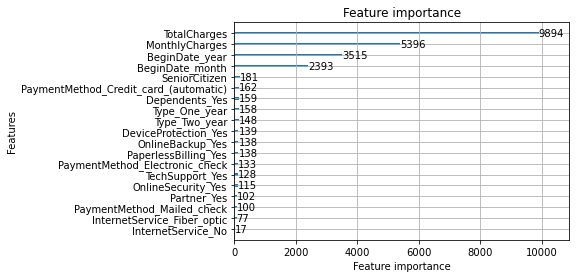

In [47]:
model = LGBMClassifier(**study.best_params, random_state=RANDOM_STATE)
model.fit(features_train, target_train)
plot_importance(model)
plt.show()

4 самых важных признака:
* `TotalCharges`
* `MonthlyCharges`
* `BeginDate_year`
* `BeginDate_month`

В итоге, больше всего влияет счет на оплату и время, которые клиент был с компанией. Скорее всего, чем дольше остается клиент, тем больше `TotalCharges` и тем меньше вероятность, что клиент уйдет. Если это так, то важно удерживать новых клиентов, поскольку у них и будет самая высокая вероятность уйти.

Построим ROC-кривую:

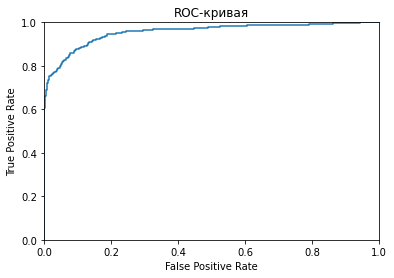

In [48]:
probabilities_valid = model.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

## Вывод
Мы обучили адекватную модель, которая соответствует поставленным требованиям. Для борьбы с дизбалансом использовался `SMOTE`, для поиска оптимальных параметров - `Optuna`. 

Лучший результат показал бустинг `LGBMClassifier` с гиперпараметрами: 

* `{'learning_rate': 0.5619493099944152, 'n_estimators': 2006, 'max_depth': 2, 'min_child_samples': 119, 'num_leaves': 196, 'min_data_per_group': 161}`. 

Показатели `ROC AUC` - 0.88

Показатели `Accuracy` - 0.91

## Отчет

Все пункты плана были выполнены. Как и планировалось, мы создали новый столбец как целевой признак, заполнили пропуски, кодировали данные с OHE, получили тестовую и обучающую выборки, обучили модели, выбрали лучшую и протестировали её.

Трудности, с которыми столкнулись по ходу работы:
* В данных были некоторые пропуски, но мы нашли способ их аутентично заполнить
* После анализа корреляций стало очевидно, что некоторые данные только создадут лишний шум для модели, поэтому мы их удалили
* В данных наблюдался дизбаланс классов, что негативно отразилось бы на обучении модели, поэтому мы использовали `SMOTE`, чтобы от него избавиться
* Для поиска оптимальных гиперпараметров моделей использовали `Optuna` с широким разбросом гиперпараметров, что может занять много времени, зато позволило достичь хороших показателей метрик

Ключевые шаги:
* **Первоначальный анализ данных:**
    * Загрузили данные и проанализировали их по отдельности
    * Объеденили датасеты, посмотрели на общий анализ с помощью `ProfileReport`
    * Провели анализ корреляций
* **Предобработка данных:**
    * Создали новый столбец `Leaving`, который служит целевым признаком
    * Удалили столбцы без корреляций, которые создавали бы лишний шум для модели
    * Заполнили пропуски
    * Закодировали данные с OHE
    * Получили тестовую и обучающую выборку
    * Избавились от дизбаланса классов с помощью `SMOTE`
* **Обучили несколько моделей c `Optuna`:**
    * LogisticRegression
    * RandomForestClassifier
    * CatBoostClassifier
    * XGBClassifier
    * LGBMClassifier
* **Тестирование лучшей модели (LGBMClassifier):**
    * Проверили модель на адекватность
    * Посмотрели на важности признаков
    * Визуализировали ROC-кривую

Итоговая модель -  бустинг `LGBMClassifier` 
* Гиперпараметры: `{'learning_rate': 0.5619493099944152, 'n_estimators': 2006, 'max_depth': 2, 'min_child_samples': 119, 'num_leaves': 196, 'min_data_per_group': 161}` 
* Важность признаков для итоговой модели:

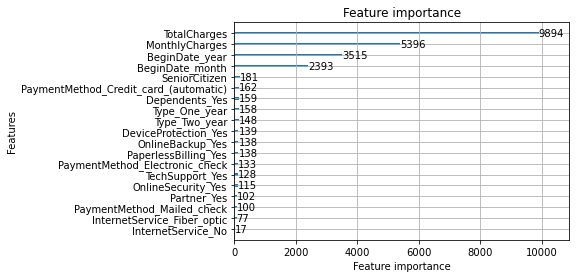

Больше всего на модель влияют 4 признака:
* `TotalCharges`
* `MonthlyCharges`
* `BeginDate_year`
* `BeginDate_month`

Показатели метрик:
* `ROC AUC` - 0.88
* `Accuracy` - 0.91
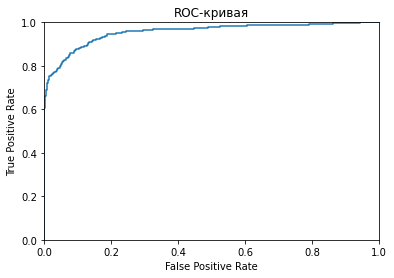